In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

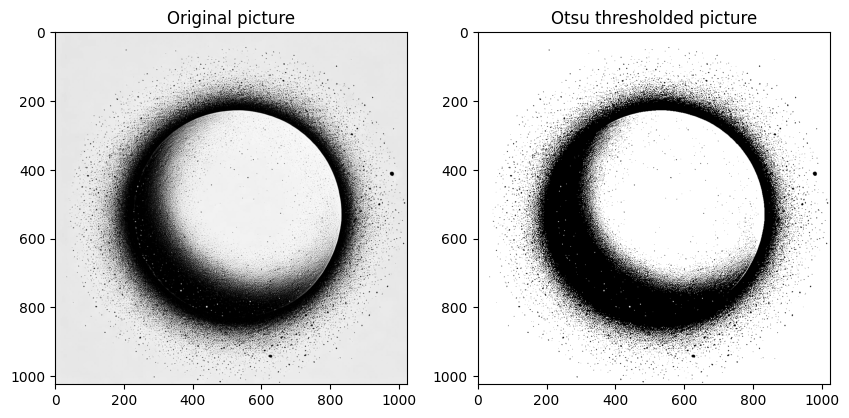

In [13]:
# Read image in grayscale
img = cv2.imread('binary_image.png', 0)

# Apply Otsu
_, otsu_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show original and threshold image
plt.figure(figsize=(10, 5))

# Original picture
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original picture')

# Otsu picture
plt.subplot(1, 2, 2)
plt.imshow(otsu_img, cmap='gray')
plt.title('Otsu thresholded picture')

plt.show()

In [14]:
def clean_segmentation(img, operation, kernel_size=(5, 5)):
    # Create a kernel for morphological operation
    kernel = np.ones(kernel_size, np.uint8)
    
    # Check which operation to apply
    if operation == 'opening':
        # Apply opening (erosion then dilation)
        clean_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    elif operation == 'closing':
        # Apply closing (dilation then erosion)
        clean_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    else:
        raise ValueError("Operation must be 'opening' or 'closing'.")
    
    return clean_img

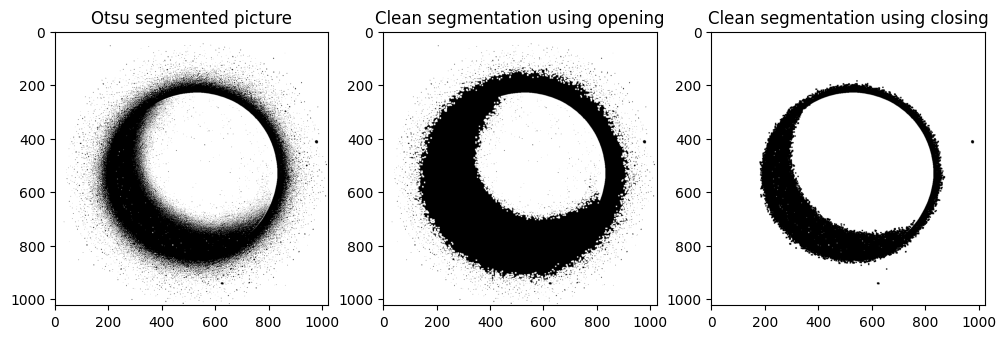

In [15]:
# Clean Otsu image with 'opening'
otsu_opening_img = clean_segmentation(otsu_img, 'opening')

# Clean Otsu image with 'closing'
otsu_closing_img = clean_segmentation(otsu_img, 'closing')

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(otsu_img, cmap='gray')
plt.title('Otsu segmented picture')

plt.subplot(1, 3, 2)
plt.imshow(otsu_opening_img, cmap='gray')
plt.title('Clean segmentation using opening')

plt.subplot(1, 3, 3)
plt.imshow(otsu_closing_img, cmap='gray')
plt.title('Clean segmentation using closing')

plt.show()